## Load and Create Dataset

In [1]:
pip install google-cloud-bigquery


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:


# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()


def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()

In [19]:
df = QUERY("""
  SELECT
    r.subject_id,
    r.stay_id,
    r.hadm_id,
    r.readmit_stay_id,
    EXTRACT(DAYOFWEEK FROM edadmitdate) AS admit_dow,
    EXTRACT(MONTH FROM edadmitdate) AS admit_month,
    EXTRACT(YEAR FROM edadmitdate) AS admit_year,
    EXTRACT(DAYOFWEEK FROM eddischargedate) AS discharge_dow,
    EXTRACT(MONTH FROM eddischargedate) AS discharge_month,
    EXTRACT(YEAR FROM eddischargedate) AS discharge_year,
    edadmithour,
    eddischargehour,
    LOS_hr,
    days_to_readmission,
    is_readmission,
    arrival_transport,
    disposition,
    gender,
    anchor_age,
    insurance,
    marital_status,
    language,
    age_group,
    race,
    race_group,
    temperature,
    heartrate,
    resprate,
    o2sat,
    sbp,
    dbp,
    acuity,
    m.name AS med_name,
    mental_health_category,
    had_readmission_within_30
  

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
  
LEFT JOIN
    `physionet-data.mimiciv_ed.triage` AS t
ON 
    r.stay_id = t.stay_id
LEFT JOIN 
    `physionet-data.mimiciv_ed.medrecon` AS m
ON  
    r.stay_id = m.stay_id
  
WHERE d.is_mh_disorder = 1

""")

In [8]:
df.head()

,subject_id,stay_id,hadm_id,readmit_stay_id,admit_dow,admit_month,admit_year,discharge_dow,discharge_month,discharge_year,...,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,name,mental_health_category,had_readmission_within_30
0,11777291,31257318,<NA>,<NA>,2,7,2186,3,7,2186,...,97.600000000,97.000000000,18.000000000,100.000000000,112.000000000,57.000000000,3.000000000,None,Substance-Related Mental Disorders,0
1,18474687,33148292,<NA>,<NA>,3,5,2187,3,5,2187,...,98.900000000,64.000000000,12.000000000,96.000000000,117.000000000,72.000000000,3.000000000,None,Substance-Related Mental Disorders,0
2,11008121,34429596,<NA>,<NA>,6,7,2117,7,7,2117,...,96.800000000,73.000000000,18.000000000,96.000000000,121.000000000,80.000000000,2.000000000,None,Substance-Related Mental Disorders,0
3,11141655,30296577,25767596,<NA>,4,5,2156,5,5,2156,...,97.500000000,64.000000000,18.000000000,None,121.000000000,85.000000000,2.000000000,Zyrtec,Mood Disorders,0
4,11141655,30296577,25767596,<NA>,4,5,2156,5,5,2156,...,97.500000000,64.000000000,18.000000000,None,121.000000000,85.000000000,2.000000000,Allegra Allergy,Mood Disorders,0


In [14]:
df.shape

(440045, 35)

### Check for NaNs

In [15]:
df.isnull().sum()

subject_id                        0
stay_id                           0
hadm_id                      140552
readmit_stay_id              241391
admit_dow                         0
admit_month                       0
admit_year                        0
discharge_dow                     0
discharge_month                   0
discharge_year                    0
edadmithour                       0
eddischargehour                   0
LOS_hr                            0
days_to_readmission          241391
is_readmission                    0
arrival_transport                 0
disposition                       0
gender                            0
anchor_age                       18
insurance                     46969
marital_status                21548
language                      16710
age_group                         0
race                              0
race_group                        0
temperature                   16244
heartrate                     10843
resprate                    

There is quite of bit of NaNs in the data. However, some NaNs are expected in hadm_id, not all patients have an associated hadm_id or readmit_stay_id, days_to_readmission, med_name (medication name).

In [20]:
df.fillna({
    'days_to_readmission':0,
    'anchor_age': np.round(df['anchor_age'].mean(), 0),
    'temperature': df['temperature'].mean(),
    'heartrate': df['heartrate'].mean(),
    'resprate': df['resprate'].mean(),
    'o2sat': df['o2sat'].mean(),
    'sbp': df['sbp'].mean(),
    'dbp': df['dbp'].mean(),
    'acuity': df['acuity'].mean()
}, inplace=True)

In [21]:
df.isnull().sum()

subject_id                        0
stay_id                           0
hadm_id                      140552
readmit_stay_id              241391
admit_dow                         0
admit_month                       0
admit_year                        0
discharge_dow                     0
discharge_month                   0
discharge_year                    0
edadmithour                       0
eddischargehour                   0
LOS_hr                            0
days_to_readmission               0
is_readmission                    0
arrival_transport                 0
disposition                       0
gender                            0
anchor_age                        0
insurance                     46969
marital_status                21548
language                      16710
age_group                         0
race                              0
race_group                        0
temperature                       0
heartrate                         0
resprate                    

### Drop Duplicates

In [22]:
# Drop any duplicates if there are any in the data
df.drop_duplicates(inplace=True)

In [23]:
df.shape

(354028, 35)

### Clean and Transform Columns

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354028 entries, 0 to 440044
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   subject_id                 354028 non-null  Int64 
 1   stay_id                    354028 non-null  Int64 
 2   hadm_id                    238235 non-null  Int64 
 3   readmit_stay_id            164094 non-null  Int64 
 4   admit_dow                  354028 non-null  Int64 
 5   admit_month                354028 non-null  Int64 
 6   admit_year                 354028 non-null  Int64 
 7   discharge_dow              354028 non-null  Int64 
 8   discharge_month            354028 non-null  Int64 
 9   discharge_year             354028 non-null  Int64 
 10  edadmithour                354028 non-null  Int64 
 11  eddischargehour            354028 non-null  Int64 
 12  LOS_hr                     354028 non-null  Int64 
 13  days_to_readmission        354028 non-null  Int64

Cleaning/Transformation Tasks
- Convert gender column to numeric binary
- Change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
- Unmarried individuals, feature engineer a binary variable, married vs unmarried
- Black/African Patiants, feature engineer a binary variable, Black/African?
- PORTUGUESE Patiants, feature engineer a binary variable, PORTUGUESE?
- Cuban Patiants, feature engineer a binary variable, Cuban?
- BLACK/AFRICAN AMERICAN patiants, feature engineer a binary variable, BLACK/AFRICAN AMERICAN?
- Puerto Rican Patiants, feature engineer a binary variable, Puerto Rican?
- Unknown Patiants, feature engineer a binary variable, Unknown?
- Hispanic or Latino Patiants, feature engineer a binary variable, Hispanic or Latino?
- Honduran Patiants, feature engineer a binary variable, Honduran?
- Patients 50 - 59
- Patients 40 - 49
- Num of Comorbitites
- Various medications (Create medication frequiences accounting for medications not listed by setting the default to 0) -> compute frequencies on the training set to prevent data leakage

In [25]:
# Change gender column to a binary
df['gender'] = df['gender'].map({'F':0,'M':1})

In [26]:
# change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
def F(x):
    if x <= 38:
        C = x
        return (C * 9/5) + 32
    else:
        return x
df['temperature'] = df['temperature'].astype(float)
df['temperature'].apply(lambda x: F(x))
df['heartrate'] = df['heartrate'].astype(float)
df['resprate'] = df['resprate'].astype(float)
df['o2sat'] = df['o2sat'].astype(float)
df['sbp'] = df['sbp'].astype(float)
df['dbp'] = df['dbp'].astype(float)
df['acuity'] = df['acuity'].astype(float)

In [27]:
# Create an unmarried vs married column from marital status column
print(df['marital_status'].unique())
df['marital_status'] = df['marital_status'].map({'None':1,'MARRIED':1,'WIDOWED':0,'DIVORCED':0,'SINGLE':0})
df.rename(columns={'marital_status':'is_married'},inplace=True)

[None 'SINGLE' 'WIDOWED' 'MARRIED' 'DIVORCED']


In [28]:
# Feature engineer a binary variable for these races:
#  - Black/African
#  - American Indian/Alaska Native Patiants
#  - PORTUGUESE
#  - Cuban
#  - BLACK/AFRICAN AMERICAN
#  - Puerto Rican
#  - Unknown
#  - Hispanic or Latino
#  - Honduran

print(df['race'].unique())
df['Black/African'] = (df['race'] == 'BLACK/AFRICAN').astype(int)
df['American Indian/Alask Native'] = (df['race'] == 'AMERICAN INDIAN/ALASKA NATIVE').astype(int)
df['Portueguese'] = (df['race'] == 'PORTUGUESE').astype(int)
df['Cuban'] = (df['race'] == 'HISPANIC/LATINO - CUBAN').astype(int)
df['Puerto Rican'] = (df['race'] ==  'HISPANIC/LATINO - PUERTO RICAN').astype(int)
df['African American'] = (df['race'] ==  'BLACK/AFRICAN AMERICAN').astype(int)
df['Unknown'] = (df['race'] ==  'UNKNOWN').astype(int)
df['Puerto Rican'] = (df['race'] ==  'HISPANIC/LATINO - PUERTO RICAN').astype(int)
df['Hispanic or Latino'] = (df['race'] ==  'HISPANIC OR LATINO').astype(int)
df['Honduran'] = (df['race'] == 'HISPANIC/LATINO - HONDURAN').astype(int)

['ASIAN' 'ASIAN - CHINESE' 'OTHER' 'WHITE' 'BLACK/AFRICAN AMERICAN'
 'HISPANIC/LATINO - PUERTO RICAN' 'UNKNOWN' 'BLACK/AFRICAN'
 'WHITE - BRAZILIAN' 'BLACK/CAPE VERDEAN' 'HISPANIC OR LATINO'
 'ASIAN - ASIAN INDIAN' 'WHITE - OTHER EUROPEAN'
 'HISPANIC/LATINO - MEXICAN' 'HISPANIC/LATINO - HONDURAN'
 'HISPANIC/LATINO - DOMINICAN' 'HISPANIC/LATINO - SALVADORAN'
 'ASIAN - KOREAN' 'BLACK/CARIBBEAN ISLAND' 'WHITE - EASTERN EUROPEAN'
 'PORTUGUESE' 'WHITE - RUSSIAN' 'HISPANIC/LATINO - CUBAN'
 'HISPANIC/LATINO - COLUMBIAN' 'HISPANIC/LATINO - GUATEMALAN'
 'AMERICAN INDIAN/ALASKA NATIVE'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' 'UNABLE TO OBTAIN'
 'MULTIPLE RACE/ETHNICITY' 'PATIENT DECLINED TO ANSWER' 'SOUTH AMERICAN'
 'ASIAN - SOUTH EAST ASIAN' 'HISPANIC/LATINO - CENTRAL AMERICAN']


In [29]:
# Feature engineer binary variables for Patients 50 - 59 and Patients 40 - 49
print(df['age_group'].unique())
df['50s'] = (df['age_group'] == '50-59').astype(int)
df['40s'] = (df['age_group'] == '40-49').astype(int)

['20-29' '30-39' '40-49' '50-59' '10-19' '80-89' '60-69' '70-79' '90+'
 'Unknown']


In [32]:
# Calculate the number of comorbities per patient per visit

comorbities = QUERY("""
  SELECT
    subject_id,
    stay_id,
    SUM(num_comorbities) AS num_comorbitites
    FROM
    (SELECT
      d.subject_id,
      d.stay_id,
      CASE
        WHEN seq_num > 1 THEN 1
        ELSE 0
      END AS num_comorbities
    FROM
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

    WHERE d.is_mh_disorder = 1
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  subject_id,stay_id

""")

In [37]:
# merge the number of comorbitites with the main dataframe on subject_id and stay_id
df_cleaned = df.merge(comorbities,how='left',on=['subject_id','stay_id'])

In [ ]:
# calculate the total number of patients per day

In [ ]:
# calcaulate the previous number of visits preceeding a readmission visit


In [ ]:
# create a binary variable to indiciate whether a patient LWBS or was treated prior to leaving the facility


### Identify Outliers

In [34]:
df_cleaned.describe()

,subject_id,stay_id,hadm_id,readmit_stay_id,admit_day,admit_month,admit_year,discharge_day,discharge_month,discharge_year,...,American Indian/Alask Native,Portueguese,Cuban,Puerto Rican,African American,Unknown,Hispanic or Latino,Honduran,50s,40s
count,310229.0,310229.0,209867.0,151470.0,310229.0,310229.0,310229.0,310229.0,310229.0,310229.0,...,310229.000000,310229.000000,310229.000000,310229.000000,310229.000000,310229.000000,310229.000000,310229.000000,310229.000000,310229.000000
mean,15048201.553253,35065427.733458,25029953.786393,35081513.000779,15.480787,6.6372,2159.035232,15.584268,6.6372,2159.035232,...,0.009316,0.004626,0.002369,0.037211,0.225340,0.013416,0.029298,0.003733,0.278011,0.264347
std,2611961.562933,2880811.994012,2878358.962107,2889129.866771,8.768046,3.479438,24.737276,8.769821,3.479438,24.737276,...,0.096067,0.067855,0.048617,0.189279,0.417807,0.115048,0.168640,0.060982,0.448019,0.440985
min,10000507.0,30000017.0,20000200.0,30000017.0,1.0,1.0,2110.0,1.0,1.0,2110.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13050816.0,32589714.0,22525788.0,32613679.0,8.0,4.0,2139.0,8.0,4.0,2139.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15302549.0,35105277.0,25052308.0,35142226.0,15.0,7.0,2161.0,16.0,7.0,2161.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17123250.0,37568988.0,27489717.0,37574202.0,23.0,10.0,2179.0,23.0,10.0,2179.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,19999466.0,39999964.0,29999277.0,39999964.0,31.0,12.0,2211.0,31.0,12.0,2211.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- There are outliers in just about every column. So, I'll have to handle these outliers because they mess up correlations

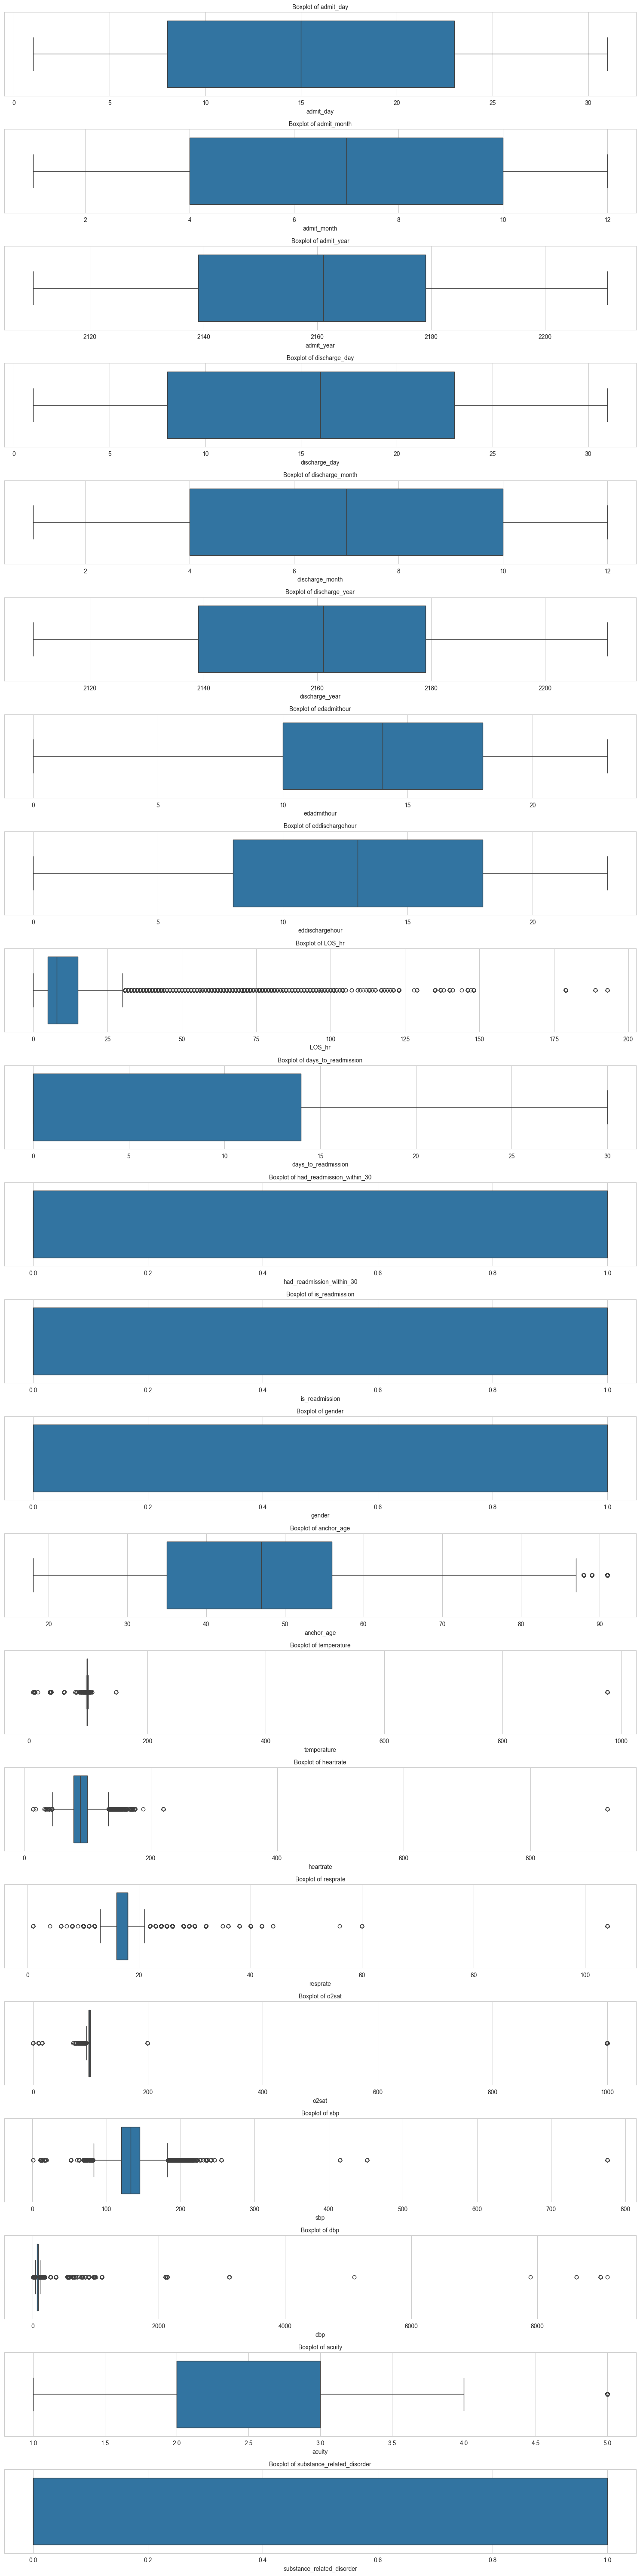

In [14]:
# Create Boxplots to identify Outliers
# Filter numeric columns
numeric_cols = df.drop(['subject_id','stay_id','hadm_id','readmit_stay_id'],axis=1).select_dtypes(include=['int64', 'Int64', 'float64']).columns

# Set up the plot grid
plt.figure(figsize=(15, 60))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}', fontsize=10)
    plt.tight_layout()

plt.show()

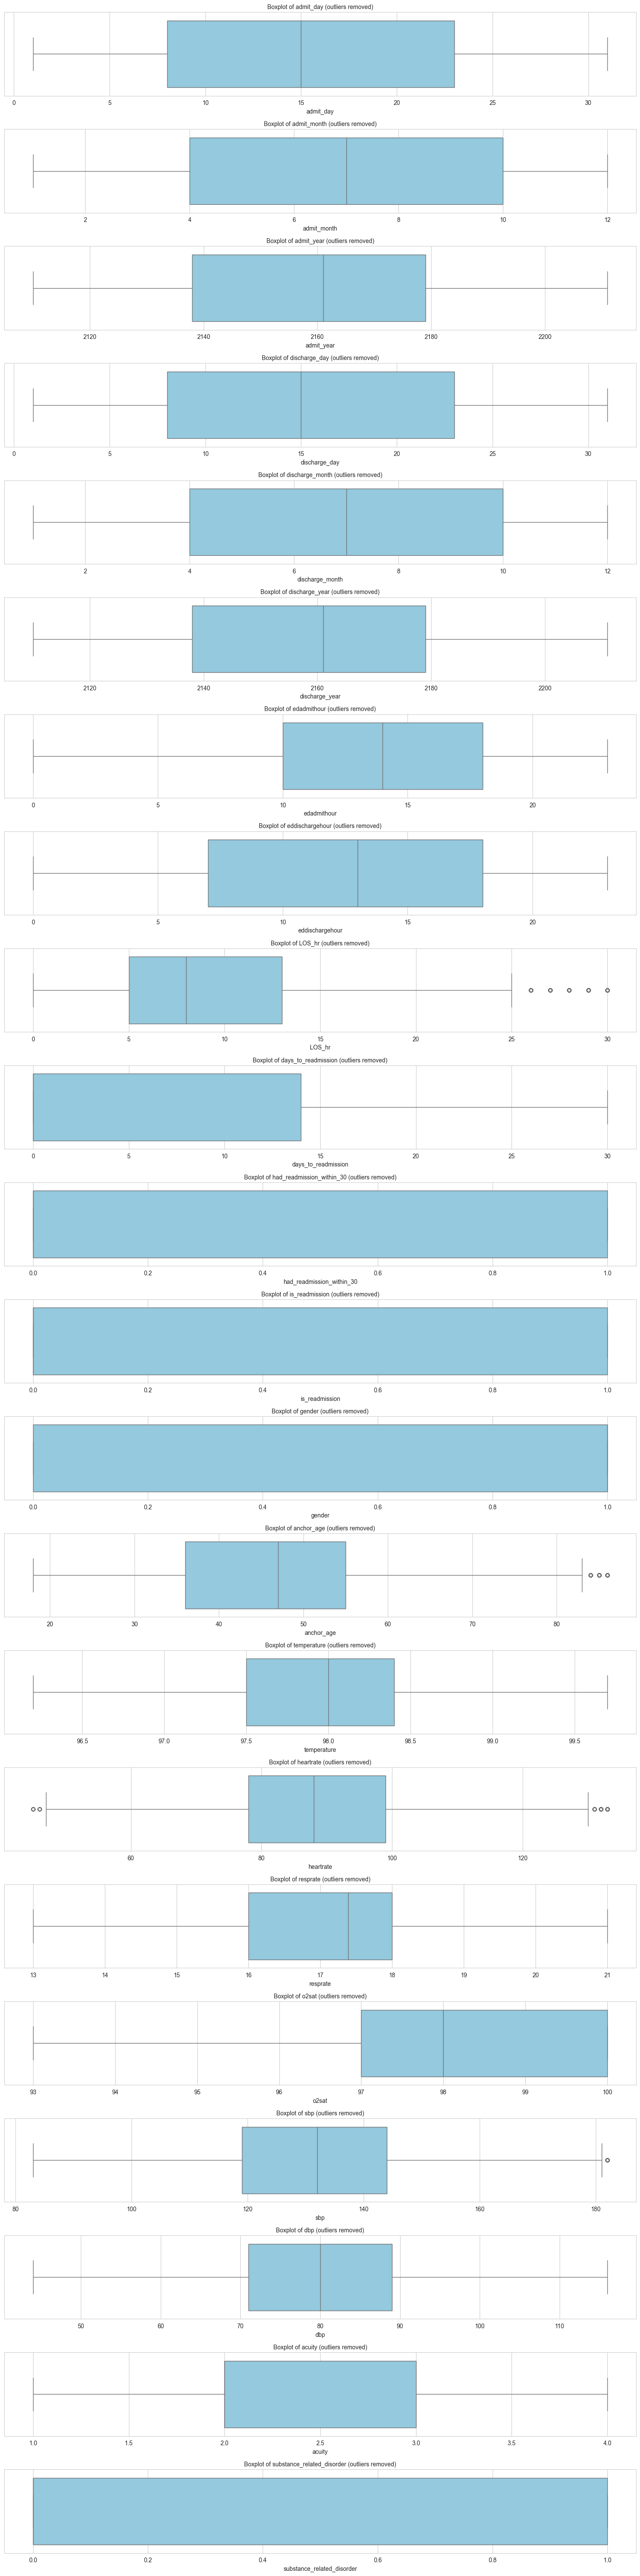

In [15]:
# use basic IQR method to remove outliers
df_cleaned = df.copy()
# Apply IQR filtering
for col in numeric_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

# Plot boxplots for the cleaned data
plt.figure(figsize=(15, 60))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df_cleaned[col], color='skyblue')
    plt.title(f'Boxplot of {col} (outliers removed)', fontsize=10)
    plt.tight_layout()

plt.show()

### Correlation Analysis

<Axes: >

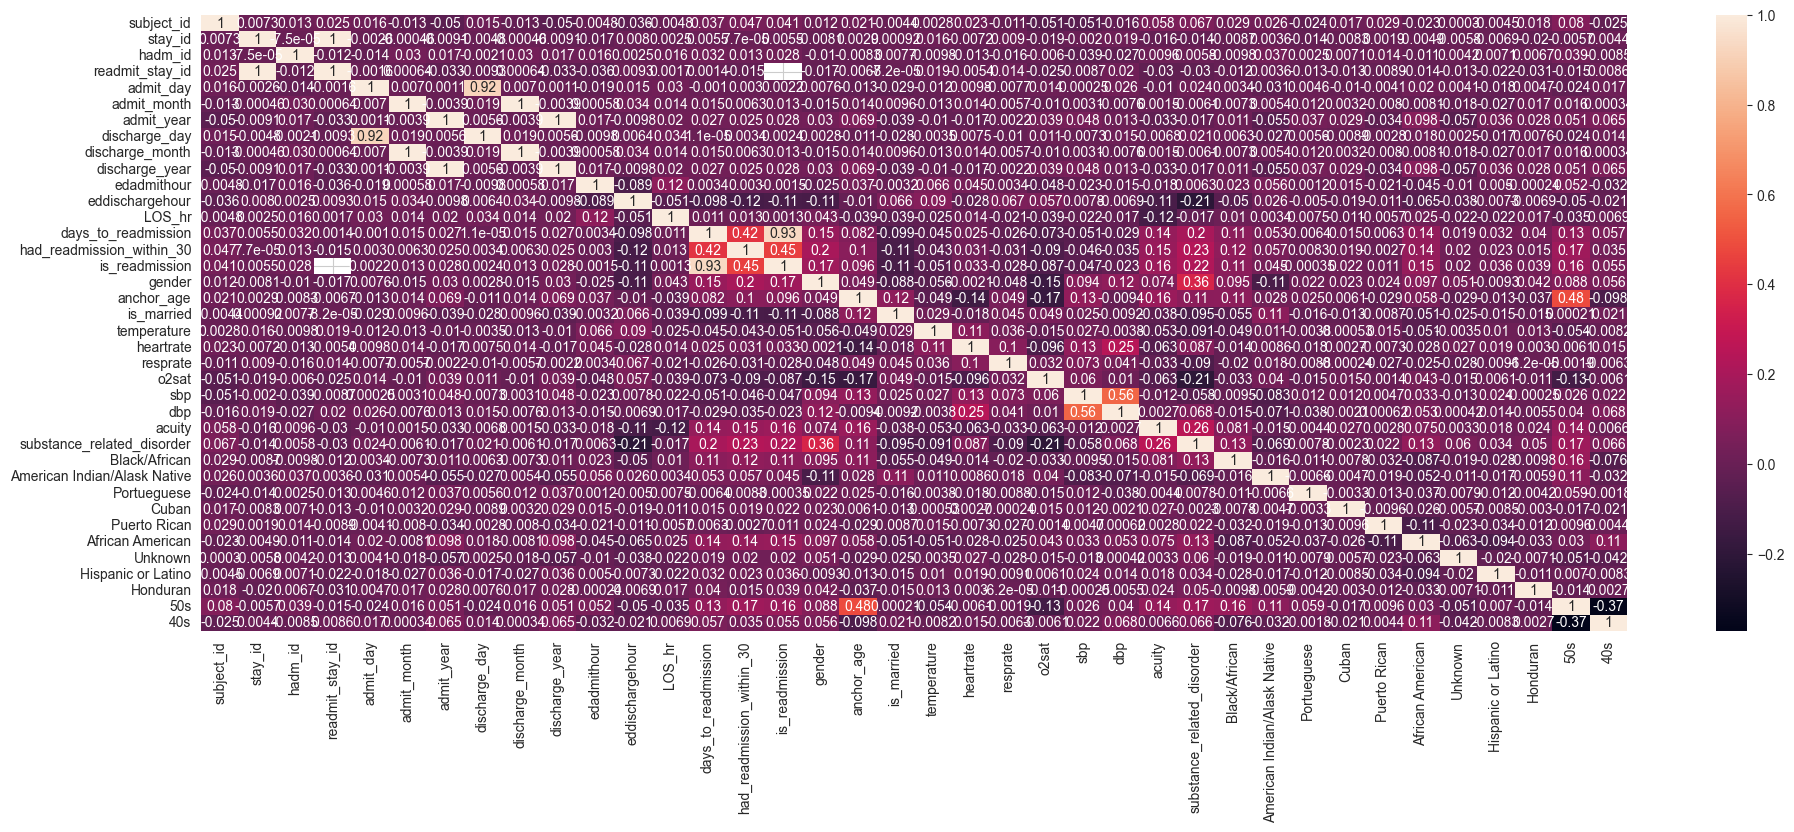

In [37]:
corr = df.corr(method='spearman',numeric_only=True)
plt.figure(figsize=(23,8))
sns.heatmap(corr,annot=True)

In [17]:
categorical_cols = df.drop(['subject_id','stay_id','hadm_id','readmit_stay_id'],axis=1).select_dtypes(include=['object'])

In [18]:
categorical_cols.nunique()

arrival_transport       5
disposition             8
insurance               5
marital_status          4
language               25
age_group              10
race                   33
race_group              9
name                 4777
dtype: int64

In [19]:


onehot_categories = pd.get_dummies(categorical_cols,dtype='Int64',drop_first=True)

In [20]:
onehot_categories.head()

,arrival_transport_HELICOPTER,arrival_transport_OTHER,arrival_transport_UNKNOWN,arrival_transport_WALK IN,disposition_ELOPED,disposition_EXPIRED,disposition_HOME,disposition_LEFT AGAINST MEDICAL ADVICE,disposition_LEFT WITHOUT BEING SEEN,disposition_OTHER,...,name_ziprasidone HCl [Geodon],name_zoledronic acid-mannitol-water [Reclast],name_zolmitriptan,name_zolmitriptan [Zomig],name_zolpidem,name_zolpidem [Ambien CR],name_zolpidem [Ambien],name_zonisamide,name_zonisamide [Zonegran],name_zoster vaccine live (PF) [ZOSTAVAX (PF)]
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
